# Learning of Process Representations Using Recurrent Neural Networks

In [1]:
import numpy as np
import pandas as pd

from replearn.eventlog import EventLog

from replearn.embedding_predict import EmbeddingPredict
from replearn.autoencoder import AutoencoderRepresentation
from replearn.doc2vec import Doc2VecRepresentation

from replearn.clustering import Clustering

from replearn.evaluation import Evaluation

# !pip install levenshtein
from Levenshtein import distance as led
import os

from tqdm import tqdm

### General Parameters

In [2]:
event_log_path = '../logs/'
case_attributes = None # auto-detect attributes
event_attributes = ['concept:name', 'user'] # use activity name and user
true_cluster_label = 'cluster'

n_epochs = 10         #[10, 25]
n_batch_size = 64
n_clusters = 5
vector_size = 32      #[2, 3, 4, 8, 16, 32, 64, 128]

clustering_method = "agglomerative" # ["k_means", "agglomerative"]

## Bag of Activities (BOA)

In [3]:
# BOA
boa_results = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()

        # vector representation
        activities = event_log._event_attribute_encodes[0]
        feature_vector = []
        
        for i in range(len(event_log.case_lens)):
            feature_vector.append(activities[i])
        feature_vector = np.array(feature_vector)
        
        # clustering
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')
        
        # evaluation
        cluster_result = cluster_analysis.evaluate() # 1. Metric (F1-BCubed)
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        boa_results[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.42s/eventlog]


## Levenshtein Distance (LED)

In [4]:
# LED
led_results = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()

        # vector representation
        activities = event_log._event_attribute_encodes[0]
        feature_vector = []
        for i in range(len(event_log.case_lens)):
            feature_vector.append(activities[i])
        feature_vector = np.array(feature_vector)
        
        print("ok")
        
        # clustering
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, metric=led)
        
        print("end")
        
        # evaluation
        cluster_result = cluster_analysis.evaluate() # 1. Metric (F1-BCubed)
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        led_results[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

  0%|                                                                                      | 0/9 [00:00<?, ?eventlog/s]

ok
end


 11%|████████▋                                                                     | 1/9 [00:01<00:15,  1.97s/eventlog]

ok
end


 22%|█████████████████▎                                                            | 2/9 [00:04<00:16,  2.37s/eventlog]

ok
end


 33%|██████████████████████████                                                    | 3/9 [00:07<00:14,  2.46s/eventlog]

ok
end


 44%|██████████████████████████████████▋                                           | 4/9 [00:09<00:12,  2.43s/eventlog]

ok
end


 56%|███████████████████████████████████████████▎                                  | 5/9 [00:12<00:10,  2.58s/eventlog]

ok
end


 67%|████████████████████████████████████████████████████                          | 6/9 [00:15<00:07,  2.62s/eventlog]

ok
end


 78%|████████████████████████████████████████████████████████████▋                 | 7/9 [00:17<00:05,  2.59s/eventlog]

ok
end


 89%|█████████████████████████████████████████████████████████████████████▎        | 8/9 [00:20<00:02,  2.64s/eventlog]

ok
end


100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.59s/eventlog]


## Autoencoder

In [5]:
# hyperparameters
n_epochs = 10         #[10, 25]
n_batch_size = 64
n_clusters = 5
vector_size = 32      #[2, 3, 4, 8, 16, 32, 64, 128]

clustering_method = "agglomerative" # ["k_means", "agglomerative"]

In [6]:
# Autoencoder
results_autoencoder = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d
        
        # init and train autoencoder
        autoencoder = AutoencoderRepresentation(event_log)
        autoencoder.build_model(input_dim=sequences.shape[1], encoder_dim=vector_size)
        autoencoder.fit(batch_size=n_batch_size, epochs=n_epochs, verbose=True)

        # get feature vector (hidden representation)
        feature_vector = autoencoder.predict()
        
        # cluster feature vector (cluster all case embeddings into n_clusters)
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')
        
        # evaluate clustered embeddings (by comparing it to event_log 'cluster' entry)
        cluster_result = cluster_analysis.evaluate() # 1. Metric (F1-BCubed)
        
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        results_autoencoder[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

  0%|                                                                                      | 0/9 [00:00<?, ?eventlog/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 2s 29ms/step - loss: 0.2381
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 0.1508
Epoch 3/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0300
Epoch 4/10
8/8 [==============================] - 0s 25ms/step - loss: 0.0097
Epoch 5/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0093
Epoch 6/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0093
Epoch 7/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0093
Epoch 8/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0092
Epoch 9/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0089
Epoch 10/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0088


 11%|████████▋                                                                     | 1/9 [00:05<00:43,  5.46s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 3s 43ms/step - loss: 0.2372
Epoch 2/10
8/8 [==============================] - 0s 41ms/step - loss: 0.1283
Epoch 3/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0151
Epoch 4/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0070
Epoch 5/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0070
Epoch 6/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0070
Epoch 7/10
8/8 [==============================] - 0s 54ms/step - loss: 0.0070
Epoch 8/10
8/8 [==============================] - 0s 59ms/step - loss: 0.0069
Epoch 9/10
8/8 [==============================] - 0s 49ms/step - loss: 0.0069
Epoch 10/10
8/8 [==============================] - 0s 61ms/step - loss: 0.0068


 22%|█████████████████▎                                                            | 2/9 [00:13<00:48,  6.92s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 3s 58ms/step - loss: 0.2340
Epoch 2/10
8/8 [==============================] - 0s 45ms/step - loss: 0.1156
Epoch 3/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0134
Epoch 4/10
8/8 [==============================] - 0s 46ms/step - loss: 0.0066
Epoch 5/10
8/8 [==============================] - 0s 47ms/step - loss: 0.0067
Epoch 6/10
8/8 [==============================] - 0s 45ms/step - loss: 0.0067
Epoch 7/10
8/8 [==============================] - 0s 44ms/step - loss: 0.0066
Epoch 8/10
8/8 [==============================] - 0s 44ms/step - loss: 0.0065
Epoch 9/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0066
Epoch 10/10
8/8 [==============================] - 0s 49ms/step - loss: 0.0065


 33%|██████████████████████████                                                    | 3/9 [00:21<00:43,  7.30s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 2s 52ms/step - loss: 0.2351
Epoch 2/10
8/8 [==============================] - 0s 56ms/step - loss: 0.1160
Epoch 3/10
8/8 [==============================] - 0s 55ms/step - loss: 0.0120
Epoch 4/10
8/8 [==============================] - 0s 55ms/step - loss: 0.0065
Epoch 5/10
8/8 [==============================] - 0s 54ms/step - loss: 0.0065
Epoch 6/10
8/8 [==============================] - 0s 54ms/step - loss: 0.0065
Epoch 7/10
8/8 [==============================] - 0s 52ms/step - loss: 0.0064
Epoch 8/10
8/8 [==============================] - 0s 54ms/step - loss: 0.0064
Epoch 9/10
8/8 [==============================] - 0s 52ms/step - loss: 0.0064
Epoch 10/10
8/8 [==============================] - 0s 53ms/step - loss: 0.0064


 44%|██████████████████████████████████▋                                           | 4/9 [00:29<00:38,  7.72s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 3s 65ms/step - loss: 0.2359
Epoch 2/10
8/8 [==============================] - 1s 63ms/step - loss: 0.1160
Epoch 3/10
8/8 [==============================] - 1s 63ms/step - loss: 0.0105
Epoch 4/10
8/8 [==============================] - 1s 63ms/step - loss: 0.0058
Epoch 5/10
8/8 [==============================] - 1s 63ms/step - loss: 0.0058
Epoch 6/10
8/8 [==============================] - 1s 63ms/step - loss: 0.0058
Epoch 7/10
8/8 [==============================] - 1s 65ms/step - loss: 0.0059
Epoch 8/10
8/8 [==============================] - 1s 64ms/step - loss: 0.0058
Epoch 9/10
8/8 [==============================] - 1s 66ms/step - loss: 0.0058
Epoch 10/10
8/8 [==============================] - 1s 62ms/step - loss: 0.0058


 56%|███████████████████████████████████████████▎                                  | 5/9 [00:38<00:33,  8.25s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 3s 58ms/step - loss: 0.2367
Epoch 2/10
8/8 [==============================] - 0s 58ms/step - loss: 0.1236
Epoch 3/10
8/8 [==============================] - 0s 57ms/step - loss: 0.0121
Epoch 4/10
8/8 [==============================] - 0s 56ms/step - loss: 0.0063
Epoch 5/10
8/8 [==============================] - 0s 57ms/step - loss: 0.0063
Epoch 6/10
8/8 [==============================] - 0s 57ms/step - loss: 0.0063
Epoch 7/10
8/8 [==============================] - 0s 57ms/step - loss: 0.0062
Epoch 8/10
8/8 [==============================] - 0s 59ms/step - loss: 0.0063
Epoch 9/10
8/8 [==============================] - 0s 57ms/step - loss: 0.0062
Epoch 10/10
8/8 [==============================] - 1s 69ms/step - loss: 0.0063


 67%|████████████████████████████████████████████████████                          | 6/9 [00:47<00:24,  8.30s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 3s 64ms/step - loss: 0.2340
Epoch 2/10
8/8 [==============================] - 1s 69ms/step - loss: 0.1055
Epoch 3/10
8/8 [==============================] - 1s 67ms/step - loss: 0.0094
Epoch 4/10
8/8 [==============================] - 1s 67ms/step - loss: 0.0058
Epoch 5/10
8/8 [==============================] - 1s 68ms/step - loss: 0.0058
Epoch 6/10
8/8 [==============================] - 1s 69ms/step - loss: 0.0058
Epoch 7/10
8/8 [==============================] - 1s 66ms/step - loss: 0.0058
Epoch 8/10
8/8 [==============================] - 1s 71ms/step - loss: 0.0058
Epoch 9/10
8/8 [==============================] - 1s 66ms/step - loss: 0.0058
Epoch 10/10
8/8 [==============================] - 1s 66ms/step - loss: 0.0058


 78%|████████████████████████████████████████████████████████████▋                 | 7/9 [00:56<00:17,  8.63s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 3s 77ms/step - loss: 0.2322
Epoch 2/10
8/8 [==============================] - 1s 81ms/step - loss: 0.0933
Epoch 3/10
8/8 [==============================] - 1s 87ms/step - loss: 0.0066
Epoch 4/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0052
Epoch 5/10
8/8 [==============================] - 1s 83ms/step - loss: 0.0052
Epoch 6/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0052
Epoch 7/10
8/8 [==============================] - 1s 81ms/step - loss: 0.0052
Epoch 8/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0052
Epoch 9/10
8/8 [==============================] - 1s 84ms/step - loss: 0.0052
Epoch 10/10
8/8 [==============================] - 1s 81ms/step - loss: 0.0052


 89%|█████████████████████████████████████████████████████████████████████▎        | 8/9 [01:07<00:09,  9.37s/eventlog]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 3s 85ms/step - loss: 0.2354
Epoch 2/10
8/8 [==============================] - 1s 81ms/step - loss: 0.1033
Epoch 3/10
8/8 [==============================] - 1s 86ms/step - loss: 0.0071
Epoch 4/10
8/8 [==============================] - 1s 87ms/step - loss: 0.0052
Epoch 5/10
8/8 [==============================] - 1s 86ms/step - loss: 0.0052
Epoch 6/10
8/8 [==============================] - 1s 83ms/step - loss: 0.0052
Epoch 7/10
8/8 [==============================] - 1s 87ms/step - loss: 0.0052
Epoch 8/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0052
Epoch 9/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0052
Epoch 10/10
8/8 [==============================] - 1s 87ms/step - loss: 0.0052


100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [01:18<00:00,  8.71s/eventlog]


## Trace2Vec

In [7]:
#Trace2vec
results_trace2vec = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        doc2vec = Doc2VecRepresentation(event_log)
        doc2vec.build_model(append_case_attr=False, append_event_attr=False, vector_size=vector_size, concat=True, epochs=n_epochs)
        doc2vec.fit()
        
        # infer the vector from the model
        feature_vector = doc2vec.predict(epochs=50) 
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        results_trace2vec[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.95s/eventlog]


   ## Case2vec (event)
   

In [8]:
#Case2vec (event)
results_case2vec_event = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        doc2vec = Doc2VecRepresentation(event_log)
        doc2vec.build_model(append_case_attr=False, append_event_attr=True, vector_size=vector_size, concat=True, epochs=n_epochs)
        doc2vec.fit()
        
        # infer the vector from the model
        feature_vector = doc2vec.predict(epochs=50) 
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        results_case2vec_event[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.06s/eventlog]


## Case2vec (event + case)

In [9]:
#Case2vec (event+case)
results_case2vec_event_case = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        doc2vec = Doc2VecRepresentation(event_log)
        doc2vec.build_model(append_case_attr=True, append_event_attr=True, vector_size=vector_size, concat=True, epochs=n_epochs)
        doc2vec.fit()
        
        # infer the vector from the model
        feature_vector = doc2vec.predict(epochs=50) 
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, 'agglomerative', n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        results_case2vec_event_case[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.29s/eventlog]


## GRUClust

In [10]:
#GRUClust
results_gruclust = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        predictor = EmbeddingPredict(event_log)
        predictor.build_model(embedding_dim=vector_size, gru_dim=vector_size, rnn='gru')
        predictor.fit(epochs=n_epochs, batch_size=n_batch_size, verbose=True)   
        
        # infer the vector from the model
        pred_model, feature_vector, embedding_vector = predictor.predict()    
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        results_gruclust[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

  0%|                                                                                      | 0/9 [00:00<?, ?eventlog/s]

Epoch 1/10
8/8 [==============================] - 13s 22ms/step - loss: 24.8815 - dense_27_loss: 2.5169 - dense_28_loss: 2.3750 - dense_29_loss: 2.5430 - dense_30_loss: 2.3474 - dense_31_loss: 2.9157 - dense_32_loss: 2.4439 - dense_33_loss: 2.5207 - dense_34_loss: 2.4198 - dense_35_loss: 2.2652 - dense_36_loss: 2.5340 - dense_27_accuracy: 0.0600 - dense_28_accuracy: 0.1060 - dense_29_accuracy: 0.1020 - dense_30_accuracy: 0.1720 - dense_31_accuracy: 0.0980 - dense_32_accuracy: 0.1300 - dense_33_accuracy: 0.1580 - dense_34_accuracy: 0.1200 - dense_35_accuracy: 0.1880 - dense_36_accuracy: 0.0700
Epoch 2/10
8/8 [==============================] - 0s 25ms/step - loss: 21.5436 - dense_27_loss: 2.1630 - dense_28_loss: 2.0586 - dense_29_loss: 2.2229 - dense_30_loss: 2.0223 - dense_31_loss: 2.5750 - dense_32_loss: 2.0544 - dense_33_loss: 2.1709 - dense_34_loss: 2.1160 - dense_35_loss: 2.0455 - dense_36_loss: 2.1149 - dense_27_accuracy: 0.2860 - dense_28_accuracy: 0.2260 - dense_29_accuracy: 0.16

 11%|████████▋                                                                     | 1/9 [00:17<02:22, 17.77s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 22ms/step - loss: 24.9177 - dense_37_loss: 2.4818 - dense_38_loss: 2.3792 - dense_39_loss: 2.5389 - dense_40_loss: 2.3865 - dense_41_loss: 2.9440 - dense_42_loss: 2.4561 - dense_43_loss: 2.6175 - dense_44_loss: 2.4053 - dense_45_loss: 2.2618 - dense_46_loss: 2.4465 - dense_37_accuracy: 0.1260 - dense_38_accuracy: 0.1800 - dense_39_accuracy: 0.0940 - dense_40_accuracy: 0.1340 - dense_41_accuracy: 0.0900 - dense_42_accuracy: 0.1780 - dense_43_accuracy: 0.1000 - dense_44_accuracy: 0.1720 - dense_45_accuracy: 0.1360 - dense_46_accuracy: 0.1600
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 22.5856 - dense_37_loss: 2.2481 - dense_38_loss: 2.1006 - dense_39_loss: 2.3700 - dense_40_loss: 2.1531 - dense_41_loss: 2.6414 - dense_42_loss: 2.1710 - dense_43_loss: 2.3925 - dense_44_loss: 2.1920 - dense_45_loss: 2.1449 - dense_46_loss: 2.1719 - dense_37_accuracy: 0.1680 - dense_38_accuracy: 0.2560 - dense_39_accuracy: 0.16

 22%|█████████████████▎                                                            | 2/9 [00:35<02:06, 18.01s/eventlog]

Epoch 1/10
8/8 [==============================] - 14s 23ms/step - loss: 25.0179 - dense_47_loss: 2.4945 - dense_48_loss: 2.3712 - dense_49_loss: 2.5286 - dense_50_loss: 2.3864 - dense_51_loss: 2.9913 - dense_52_loss: 2.4905 - dense_53_loss: 2.5659 - dense_54_loss: 2.4426 - dense_55_loss: 2.2725 - dense_56_loss: 2.4743 - dense_47_accuracy: 0.1400 - dense_48_accuracy: 0.1480 - dense_49_accuracy: 0.1020 - dense_50_accuracy: 0.1960 - dense_51_accuracy: 0.0540 - dense_52_accuracy: 0.1560 - dense_53_accuracy: 0.1280 - dense_54_accuracy: 0.1160 - dense_55_accuracy: 0.1180 - dense_56_accuracy: 0.1360
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 23.6165 - dense_47_loss: 2.3048 - dense_48_loss: 2.2085 - dense_49_loss: 2.4929 - dense_50_loss: 2.2361 - dense_51_loss: 2.8139 - dense_52_loss: 2.3611 - dense_53_loss: 2.4196 - dense_54_loss: 2.3264 - dense_55_loss: 2.2063 - dense_56_loss: 2.2468 - dense_47_accuracy: 0.2540 - dense_48_accuracy: 0.2240 - dense_49_accuracy: 0.16

 33%|██████████████████████████                                                    | 3/9 [00:54<01:50, 18.41s/eventlog]

Epoch 1/10
8/8 [==============================] - 16s 23ms/step - loss: 24.9715 - dense_57_loss: 2.4752 - dense_58_loss: 2.3834 - dense_59_loss: 2.5328 - dense_60_loss: 2.3885 - dense_61_loss: 2.9831 - dense_62_loss: 2.4610 - dense_63_loss: 2.5960 - dense_64_loss: 2.4123 - dense_65_loss: 2.2754 - dense_66_loss: 2.4638 - dense_57_accuracy: 0.1420 - dense_58_accuracy: 0.1460 - dense_59_accuracy: 0.1280 - dense_60_accuracy: 0.1420 - dense_61_accuracy: 0.0520 - dense_62_accuracy: 0.1400 - dense_63_accuracy: 0.1260 - dense_64_accuracy: 0.1600 - dense_65_accuracy: 0.1580 - dense_66_accuracy: 0.1420
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 23.0528 - dense_57_loss: 2.2315 - dense_58_loss: 2.1794 - dense_59_loss: 2.3893 - dense_60_loss: 2.1569 - dense_61_loss: 2.7970 - dense_62_loss: 2.2848 - dense_63_loss: 2.3590 - dense_64_loss: 2.2612 - dense_65_loss: 2.1622 - dense_66_loss: 2.2313 - dense_57_accuracy: 0.2140 - dense_58_accuracy: 0.2180 - dense_59_accuracy: 0.16

 44%|██████████████████████████████████▋                                           | 4/9 [01:16<01:38, 19.62s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 25ms/step - loss: 25.0727 - dense_67_loss: 2.4617 - dense_68_loss: 2.4196 - dense_69_loss: 2.5593 - dense_70_loss: 2.3834 - dense_71_loss: 2.9647 - dense_72_loss: 2.4839 - dense_73_loss: 2.6082 - dense_74_loss: 2.4231 - dense_75_loss: 2.2741 - dense_76_loss: 2.4947 - dense_67_accuracy: 0.1400 - dense_68_accuracy: 0.1280 - dense_69_accuracy: 0.0720 - dense_70_accuracy: 0.1900 - dense_71_accuracy: 0.0740 - dense_72_accuracy: 0.1540 - dense_73_accuracy: 0.1220 - dense_74_accuracy: 0.1340 - dense_75_accuracy: 0.1100 - dense_76_accuracy: 0.1580
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 23.4064 - dense_67_loss: 2.3028 - dense_68_loss: 2.2450 - dense_69_loss: 2.4131 - dense_70_loss: 2.2268 - dense_71_loss: 2.7853 - dense_72_loss: 2.2514 - dense_73_loss: 2.4436 - dense_74_loss: 2.3053 - dense_75_loss: 2.1740 - dense_76_loss: 2.2592 - dense_67_accuracy: 0.1680 - dense_68_accuracy: 0.2080 - dense_69_accuracy: 0.18

 56%|███████████████████████████████████████████▎                                  | 5/9 [01:34<01:16, 19.09s/eventlog]

Epoch 1/10
8/8 [==============================] - 12s 23ms/step - loss: 25.1992 - dense_77_loss: 2.5128 - dense_78_loss: 2.3815 - dense_79_loss: 2.5353 - dense_80_loss: 2.4129 - dense_81_loss: 2.9733 - dense_82_loss: 2.5111 - dense_83_loss: 2.5982 - dense_84_loss: 2.4611 - dense_85_loss: 2.2975 - dense_86_loss: 2.5154 - dense_77_accuracy: 0.1080 - dense_78_accuracy: 0.1680 - dense_79_accuracy: 0.1220 - dense_80_accuracy: 0.1540 - dense_81_accuracy: 0.0740 - dense_82_accuracy: 0.1000 - dense_83_accuracy: 0.1080 - dense_84_accuracy: 0.0820 - dense_85_accuracy: 0.1360 - dense_86_accuracy: 0.1340
Epoch 2/10
8/8 [==============================] - 0s 25ms/step - loss: 23.6065 - dense_77_loss: 2.3420 - dense_78_loss: 2.2156 - dense_79_loss: 2.4509 - dense_80_loss: 2.2497 - dense_81_loss: 2.8046 - dense_82_loss: 2.3090 - dense_83_loss: 2.4208 - dense_84_loss: 2.3298 - dense_85_loss: 2.1625 - dense_86_loss: 2.3215 - dense_77_accuracy: 0.1780 - dense_78_accuracy: 0.1600 - dense_79_accuracy: 0.14

 67%|████████████████████████████████████████████████████                          | 6/9 [01:53<00:56, 18.97s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 23ms/step - loss: 25.0687 - dense_87_loss: 2.4780 - dense_88_loss: 2.3692 - dense_89_loss: 2.5775 - dense_90_loss: 2.3771 - dense_91_loss: 2.9820 - dense_92_loss: 2.5028 - dense_93_loss: 2.5748 - dense_94_loss: 2.4481 - dense_95_loss: 2.2810 - dense_96_loss: 2.4781 - dense_87_accuracy: 0.1320 - dense_88_accuracy: 0.1320 - dense_89_accuracy: 0.1020 - dense_90_accuracy: 0.1600 - dense_91_accuracy: 0.0560 - dense_92_accuracy: 0.0860 - dense_93_accuracy: 0.1140 - dense_94_accuracy: 0.0940 - dense_95_accuracy: 0.1280 - dense_96_accuracy: 0.1760
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 23.5814 - dense_87_loss: 2.2746 - dense_88_loss: 2.2107 - dense_89_loss: 2.5116 - dense_90_loss: 2.2699 - dense_91_loss: 2.8315 - dense_92_loss: 2.2783 - dense_93_loss: 2.4150 - dense_94_loss: 2.3334 - dense_95_loss: 2.1614 - dense_96_loss: 2.2951 - dense_87_accuracy: 0.2320 - dense_88_accuracy: 0.2100 - dense_89_accuracy: 0.12

 78%|████████████████████████████████████████████████████████████▋                 | 7/9 [02:11<00:37, 18.86s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 24ms/step - loss: 25.1164 - dense_97_loss: 2.4854 - dense_98_loss: 2.3866 - dense_99_loss: 2.5718 - dense_100_loss: 2.3826 - dense_101_loss: 2.9660 - dense_102_loss: 2.5250 - dense_103_loss: 2.6029 - dense_104_loss: 2.4358 - dense_105_loss: 2.2912 - dense_106_loss: 2.4691 - dense_97_accuracy: 0.1500 - dense_98_accuracy: 0.1200 - dense_99_accuracy: 0.1120 - dense_100_accuracy: 0.2000 - dense_101_accuracy: 0.0720 - dense_102_accuracy: 0.1440 - dense_103_accuracy: 0.0960 - dense_104_accuracy: 0.1080 - dense_105_accuracy: 0.1180 - dense_106_accuracy: 0.1260
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 23.7546 - dense_97_loss: 2.3607 - dense_98_loss: 2.1885 - dense_99_loss: 2.4876 - dense_100_loss: 2.2043 - dense_101_loss: 2.8572 - dense_102_loss: 2.3722 - dense_103_loss: 2.4473 - dense_104_loss: 2.3164 - dense_105_loss: 2.2374 - dense_106_loss: 2.2829 - dense_97_accuracy: 0.1740 - dense_98_accuracy: 0.2100 - de

 89%|█████████████████████████████████████████████████████████████████████▎        | 8/9 [02:31<00:18, 18.99s/eventlog]

Epoch 1/10
8/8 [==============================] - 14s 26ms/step - loss: 25.0983 - dense_107_loss: 2.5141 - dense_108_loss: 2.3715 - dense_109_loss: 2.5506 - dense_110_loss: 2.3911 - dense_111_loss: 2.9790 - dense_112_loss: 2.4688 - dense_113_loss: 2.5923 - dense_114_loss: 2.4483 - dense_115_loss: 2.2719 - dense_116_loss: 2.5107 - dense_107_accuracy: 0.1540 - dense_108_accuracy: 0.1660 - dense_109_accuracy: 0.1140 - dense_110_accuracy: 0.1720 - dense_111_accuracy: 0.0720 - dense_112_accuracy: 0.1600 - dense_113_accuracy: 0.1140 - dense_114_accuracy: 0.1260 - dense_115_accuracy: 0.1640 - dense_116_accuracy: 0.1140
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 23.9276 - dense_107_loss: 2.3800 - dense_108_loss: 2.1880 - dense_109_loss: 2.4842 - dense_110_loss: 2.2942 - dense_111_loss: 2.8530 - dense_112_loss: 2.3561 - dense_113_loss: 2.4276 - dense_114_loss: 2.3878 - dense_115_loss: 2.2025 - dense_116_loss: 2.3542 - dense_107_accuracy: 0.1740 - dense_108_accuracy: 

100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [02:51<00:00, 19.05s/eventlog]


## LSTMClust

In [11]:
#LSTM
results_lstmclust = {}

for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        predictor = EmbeddingPredict(event_log)
        predictor.build_model(embedding_dim=vector_size, gru_dim=vector_size, rnn='LSTM')
        predictor.fit(epochs=n_epochs, batch_size=n_batch_size, verbose=True)   
        
        # infer the vector from the model
        pred_model, feature_vector, embedding_vector = predictor.predict()    
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        
        results_lstmclust[file] = {"f1_bcubed":cluster_result[2], "fitness": fitness, "precision":precision, "simplicity":simplicity}

  0%|                                                                                      | 0/9 [00:00<?, ?eventlog/s]

Epoch 1/10
8/8 [==============================] - 13s 24ms/step - loss: 24.5761 - dense_117_loss: 2.4423 - dense_118_loss: 2.3197 - dense_119_loss: 2.5001 - dense_120_loss: 2.3946 - dense_121_loss: 2.9090 - dense_122_loss: 2.4291 - dense_123_loss: 2.5248 - dense_124_loss: 2.4207 - dense_125_loss: 2.2382 - dense_126_loss: 2.3974 - dense_117_accuracy: 0.1420 - dense_118_accuracy: 0.1760 - dense_119_accuracy: 0.1300 - dense_120_accuracy: 0.1500 - dense_121_accuracy: 0.0940 - dense_122_accuracy: 0.1240 - dense_123_accuracy: 0.1260 - dense_124_accuracy: 0.1900 - dense_125_accuracy: 0.1620 - dense_126_accuracy: 0.2020
Epoch 2/10
8/8 [==============================] - 0s 25ms/step - loss: 20.9301 - dense_117_loss: 1.9909 - dense_118_loss: 1.9776 - dense_119_loss: 2.1019 - dense_120_loss: 2.1288 - dense_121_loss: 2.4635 - dense_122_loss: 1.9829 - dense_123_loss: 2.1984 - dense_124_loss: 2.1034 - dense_125_loss: 1.9615 - dense_126_loss: 2.0212 - dense_117_accuracy: 0.3120 - dense_118_accuracy: 

 11%|████████▋                                                                     | 1/9 [00:18<02:28, 18.58s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 22ms/step - loss: 24.8784 - dense_127_loss: 2.4641 - dense_128_loss: 2.4049 - dense_129_loss: 2.5361 - dense_130_loss: 2.3511 - dense_131_loss: 2.9493 - dense_132_loss: 2.4583 - dense_133_loss: 2.5851 - dense_134_loss: 2.3806 - dense_135_loss: 2.2528 - dense_136_loss: 2.4959 - dense_127_accuracy: 0.2220 - dense_128_accuracy: 0.1740 - dense_129_accuracy: 0.1240 - dense_130_accuracy: 0.2080 - dense_131_accuracy: 0.0720 - dense_132_accuracy: 0.1660 - dense_133_accuracy: 0.0900 - dense_134_accuracy: 0.1740 - dense_135_accuracy: 0.1400 - dense_136_accuracy: 0.1680
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 21.5728 - dense_127_loss: 2.1655 - dense_128_loss: 2.0759 - dense_129_loss: 2.2704 - dense_130_loss: 1.9932 - dense_131_loss: 2.5938 - dense_132_loss: 2.0574 - dense_133_loss: 2.3264 - dense_134_loss: 2.0116 - dense_135_loss: 1.9460 - dense_136_loss: 2.1325 - dense_127_accuracy: 0.2800 - dense_128_accuracy: 

 22%|█████████████████▎                                                            | 2/9 [00:36<02:08, 18.35s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 28ms/step - loss: 24.9107 - dense_137_loss: 2.4330 - dense_138_loss: 2.4110 - dense_139_loss: 2.5225 - dense_140_loss: 2.4016 - dense_141_loss: 2.9362 - dense_142_loss: 2.4822 - dense_143_loss: 2.5706 - dense_144_loss: 2.4653 - dense_145_loss: 2.2459 - dense_146_loss: 2.4423 - dense_137_accuracy: 0.1420 - dense_138_accuracy: 0.1200 - dense_139_accuracy: 0.1060 - dense_140_accuracy: 0.1560 - dense_141_accuracy: 0.0740 - dense_142_accuracy: 0.1520 - dense_143_accuracy: 0.0880 - dense_144_accuracy: 0.1040 - dense_145_accuracy: 0.1540 - dense_146_accuracy: 0.1440
Epoch 2/10
8/8 [==============================] - 0s 27ms/step - loss: 21.6656 - dense_137_loss: 2.1071 - dense_138_loss: 2.0366 - dense_139_loss: 2.1962 - dense_140_loss: 2.1348 - dense_141_loss: 2.5151 - dense_142_loss: 2.1178 - dense_143_loss: 2.2360 - dense_144_loss: 2.1592 - dense_145_loss: 2.0170 - dense_146_loss: 2.1458 - dense_137_accuracy: 0.2800 - dense_138_accuracy: 

 33%|██████████████████████████                                                    | 3/9 [00:55<01:50, 18.44s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 25ms/step - loss: 24.9695 - dense_147_loss: 2.4607 - dense_148_loss: 2.3716 - dense_149_loss: 2.5568 - dense_150_loss: 2.3738 - dense_151_loss: 2.9360 - dense_152_loss: 2.4908 - dense_153_loss: 2.5857 - dense_154_loss: 2.4526 - dense_155_loss: 2.2501 - dense_156_loss: 2.4915 - dense_147_accuracy: 0.1480 - dense_148_accuracy: 0.1620 - dense_149_accuracy: 0.0840 - dense_150_accuracy: 0.2160 - dense_151_accuracy: 0.0660 - dense_152_accuracy: 0.1580 - dense_153_accuracy: 0.0840 - dense_154_accuracy: 0.1480 - dense_155_accuracy: 0.1740 - dense_156_accuracy: 0.1540
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 22.0726 - dense_147_loss: 2.1372 - dense_148_loss: 2.0760 - dense_149_loss: 2.2959 - dense_150_loss: 2.0151 - dense_151_loss: 2.6330 - dense_152_loss: 2.1534 - dense_153_loss: 2.3137 - dense_154_loss: 2.2065 - dense_155_loss: 2.0474 - dense_156_loss: 2.1945 - dense_147_accuracy: 0.2820 - dense_148_accuracy: 

 44%|██████████████████████████████████▋                                           | 4/9 [01:13<01:32, 18.49s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 26ms/step - loss: 24.8394 - dense_157_loss: 2.4329 - dense_158_loss: 2.3339 - dense_159_loss: 2.5316 - dense_160_loss: 2.3819 - dense_161_loss: 2.9651 - dense_162_loss: 2.4715 - dense_163_loss: 2.5987 - dense_164_loss: 2.4649 - dense_165_loss: 2.2261 - dense_166_loss: 2.4327 - dense_157_accuracy: 0.1360 - dense_158_accuracy: 0.1620 - dense_159_accuracy: 0.0780 - dense_160_accuracy: 0.1880 - dense_161_accuracy: 0.0500 - dense_162_accuracy: 0.1160 - dense_163_accuracy: 0.1200 - dense_164_accuracy: 0.1100 - dense_165_accuracy: 0.2140 - dense_166_accuracy: 0.1560
Epoch 2/10
8/8 [==============================] - 0s 27ms/step - loss: 21.8406 - dense_157_loss: 2.1659 - dense_158_loss: 2.0352 - dense_159_loss: 2.2599 - dense_160_loss: 2.1151 - dense_161_loss: 2.5894 - dense_162_loss: 2.1277 - dense_163_loss: 2.2433 - dense_164_loss: 2.2229 - dense_165_loss: 1.9477 - dense_166_loss: 2.1335 - dense_157_accuracy: 0.2840 - dense_158_accuracy: 

 56%|███████████████████████████████████████████▎                                  | 5/9 [01:32<01:14, 18.65s/eventlog]

Epoch 1/10
8/8 [==============================] - 12s 23ms/step - loss: 24.9498 - dense_167_loss: 2.4407 - dense_168_loss: 2.3840 - dense_169_loss: 2.5190 - dense_170_loss: 2.4538 - dense_171_loss: 2.9323 - dense_172_loss: 2.4853 - dense_173_loss: 2.5819 - dense_174_loss: 2.4167 - dense_175_loss: 2.2338 - dense_176_loss: 2.5022 - dense_167_accuracy: 0.2160 - dense_168_accuracy: 0.2000 - dense_169_accuracy: 0.1080 - dense_170_accuracy: 0.1240 - dense_171_accuracy: 0.1040 - dense_172_accuracy: 0.1420 - dense_173_accuracy: 0.1320 - dense_174_accuracy: 0.1620 - dense_175_accuracy: 0.1760 - dense_176_accuracy: 0.1200
Epoch 2/10
8/8 [==============================] - 0s 25ms/step - loss: 21.2803 - dense_167_loss: 1.9914 - dense_168_loss: 2.0444 - dense_169_loss: 2.1852 - dense_170_loss: 2.1032 - dense_171_loss: 2.4556 - dense_172_loss: 2.0771 - dense_173_loss: 2.2080 - dense_174_loss: 2.0167 - dense_175_loss: 1.9487 - dense_176_loss: 2.2500 - dense_167_accuracy: 0.3320 - dense_168_accuracy: 

 67%|████████████████████████████████████████████████████                          | 6/9 [01:51<00:55, 18.62s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 25ms/step - loss: 24.8933 - dense_177_loss: 2.4897 - dense_178_loss: 2.3456 - dense_179_loss: 2.5576 - dense_180_loss: 2.3689 - dense_181_loss: 2.9561 - dense_182_loss: 2.4728 - dense_183_loss: 2.5804 - dense_184_loss: 2.4128 - dense_185_loss: 2.2491 - dense_186_loss: 2.4601 - dense_177_accuracy: 0.1120 - dense_178_accuracy: 0.1320 - dense_179_accuracy: 0.1260 - dense_180_accuracy: 0.2040 - dense_181_accuracy: 0.1120 - dense_182_accuracy: 0.1480 - dense_183_accuracy: 0.1420 - dense_184_accuracy: 0.1180 - dense_185_accuracy: 0.1220 - dense_186_accuracy: 0.1540
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 22.0958 - dense_177_loss: 2.1889 - dense_178_loss: 2.0492 - dense_179_loss: 2.3158 - dense_180_loss: 2.1248 - dense_181_loss: 2.5867 - dense_182_loss: 2.2184 - dense_183_loss: 2.2500 - dense_184_loss: 2.0768 - dense_185_loss: 2.0525 - dense_186_loss: 2.2328 - dense_177_accuracy: 0.1520 - dense_178_accuracy: 

 78%|████████████████████████████████████████████████████████████▋                 | 7/9 [02:11<00:38, 19.04s/eventlog]

Epoch 1/10
8/8 [==============================] - 14s 29ms/step - loss: 24.9892 - dense_187_loss: 2.5137 - dense_188_loss: 2.3765 - dense_189_loss: 2.5466 - dense_190_loss: 2.3777 - dense_191_loss: 2.9473 - dense_192_loss: 2.5155 - dense_193_loss: 2.5823 - dense_194_loss: 2.4179 - dense_195_loss: 2.2774 - dense_196_loss: 2.4345 - dense_187_accuracy: 0.0900 - dense_188_accuracy: 0.1360 - dense_189_accuracy: 0.0860 - dense_190_accuracy: 0.2220 - dense_191_accuracy: 0.0680 - dense_192_accuracy: 0.1260 - dense_193_accuracy: 0.0920 - dense_194_accuracy: 0.1500 - dense_195_accuracy: 0.1520 - dense_196_accuracy: 0.1800
Epoch 2/10
8/8 [==============================] - 0s 31ms/step - loss: 22.3516 - dense_187_loss: 2.2513 - dense_188_loss: 2.0947 - dense_189_loss: 2.2737 - dense_190_loss: 2.0750 - dense_191_loss: 2.6277 - dense_192_loss: 2.2308 - dense_193_loss: 2.3858 - dense_194_loss: 2.1616 - dense_195_loss: 2.0855 - dense_196_loss: 2.1655 - dense_187_accuracy: 0.1700 - dense_188_accuracy: 

 89%|█████████████████████████████████████████████████████████████████████▎        | 8/9 [02:32<00:19, 19.73s/eventlog]

Epoch 1/10
8/8 [==============================] - 13s 27ms/step - loss: 24.7236 - dense_197_loss: 2.4684 - dense_198_loss: 2.3423 - dense_199_loss: 2.4865 - dense_200_loss: 2.3761 - dense_201_loss: 2.9514 - dense_202_loss: 2.4382 - dense_203_loss: 2.5378 - dense_204_loss: 2.4457 - dense_205_loss: 2.2192 - dense_206_loss: 2.4581 - dense_197_accuracy: 0.1580 - dense_198_accuracy: 0.1800 - dense_199_accuracy: 0.1160 - dense_200_accuracy: 0.2320 - dense_201_accuracy: 0.1180 - dense_202_accuracy: 0.1680 - dense_203_accuracy: 0.1300 - dense_204_accuracy: 0.1120 - dense_205_accuracy: 0.1520 - dense_206_accuracy: 0.1300
Epoch 2/10
8/8 [==============================] - 0s 28ms/step - loss: 21.8524 - dense_197_loss: 2.1236 - dense_198_loss: 2.0981 - dense_199_loss: 2.2192 - dense_200_loss: 2.0954 - dense_201_loss: 2.6627 - dense_202_loss: 2.1296 - dense_203_loss: 2.1921 - dense_204_loss: 2.1064 - dense_205_loss: 2.0328 - dense_206_loss: 2.1926 - dense_197_accuracy: 0.2600 - dense_198_accuracy: 

100%|██████████████████████████████████████████████████████████████████████████████| 9/9 [02:51<00:00, 19.08s/eventlog]


In [12]:
# Statistics

results = {"autoencoder":results_autoencoder, "boa": boa_results, "led": led_results} 

statistics_autoencoder = pd.DataFrame(results_autoencoder).transpose()
print("Statistics for Autoencoder")
print(statistics_autoencoder.describe())

# Example statistics output for Autoencoder
f1_bcubed_mean, f1_bcubed_std = statistics_autoencoder.f1_bcubed.mean(), statistics_autoencoder.f1_bcubed.std()
fitness_mean, fitness_std = statistics_autoencoder.fitness.mean(), statistics_autoencoder.fitness.std()
precision_mean, precision_std = statistics_autoencoder.precision.mean(), statistics_autoencoder.precision.std()
simplicity_mean, simplicity_std = statistics_autoencoder.simplicity.mean(), statistics_autoencoder.simplicity.std()
count = statistics_autoencoder.count()

# Maybe do the same for the other ones

statistics_LED = pd.DataFrame(boa_results).transpose()
statistics_BOA = pd.DataFrame(led_results).transpose()
statistics_Trace2Vec = pd.DataFrame(results_trace2vec).transpose()
statistics_Case2Vec_event = pd.DataFrame(results_case2vec_event).transpose()
statistics_Case2Vec_event_case = pd.DataFrame(results_case2vec_event_case).transpose()
statistics_gruclust = pd.DataFrame(results_gruclust).transpose()
statistics_lstmclust = pd.DataFrame(results_lstmclust).transpose()

Statistics for Autoencoder
       f1_bcubed   fitness  precision  simplicity
count   9.000000  9.000000   9.000000    9.000000
mean    0.613661  0.668241   0.481897    0.719365
std     0.056777  0.099497   0.093429    0.057994
min     0.548064  0.548105   0.330856    0.635058
25%     0.558832  0.597578   0.419214    0.680444
50%     0.630201  0.660238   0.479333    0.709412
75%     0.650393  0.690384   0.556358    0.755833
max     0.699588  0.867476   0.589253    0.822662


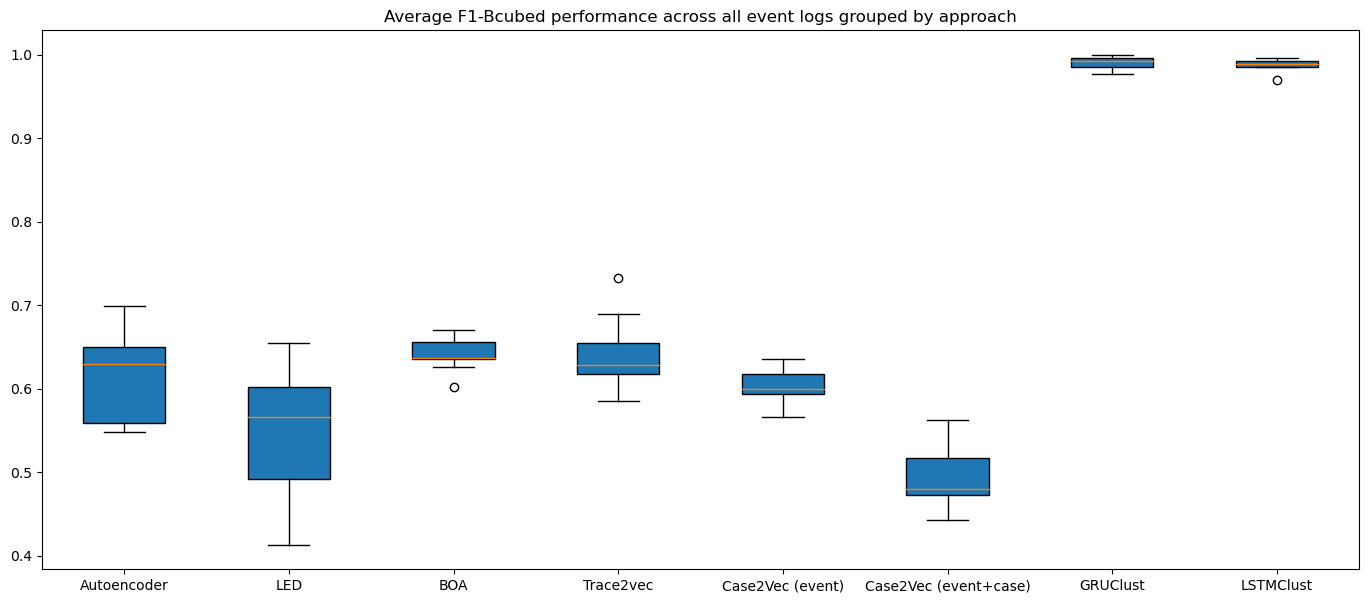

In [13]:
#plot
from matplotlib import pyplot as plt
fig = plt.figure(figsize =(17,7))
fig = plt.title("Average F1-Bcubed performance across all event logs grouped by approach")
results_of_algorithms = [statistics_autoencoder.f1_bcubed, statistics_LED.f1_bcubed, statistics_BOA.f1_bcubed, statistics_Trace2Vec.f1_bcubed, statistics_Case2Vec_event.f1_bcubed, statistics_Case2Vec_event_case.f1_bcubed, statistics_gruclust.f1_bcubed, statistics_lstmclust.f1_bcubed]

bp = plt.boxplot(results_of_algorithms, patch_artist=True, labels=['Autoencoder', 'LED', 'BOA', 'Trace2vec', 'Case2Vec (event)', 'Case2Vec (event+case)', 'GRUClust', 'LSTMClust'])
plt.show()
# <<< USE TO PLOT HERE...

